In [1]:
# We load the competition data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import (
    LabelEncoder,    
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    RandomizedSearchCV
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance

# Predicting Optimal Fertilizers

### Playground Series - Season 5, Episode 6

### Your Goal: 

Your objective is to select the best fertilizer for different weather, soil conditions and crops.

### Evaluation:

Submissions are evaluated according to the Mean Average Precision @ 3 (MAP@3).

### Submission File:

For each id in the test set, you may predict up to 3 Fertilizer Name values, with the predictions space delimited. The file should contain a header and have the following format:

id,Fertilizer Name 

750000,14-35-14 10-26-26 Urea

750000,14-35-14 10-26-26 Urea

etc

### Timeline:

Start Date - June 1, 2025

Entry Deadline - Same as the Final Submission Deadline

Team Merger Deadline - Same as the Final Submission Deadline

Final Submission Deadline - June 30, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Initial analysis

In [3]:
# We load the data

fertilizers_train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv", index_col="id")

In [4]:
fertilizers_train.shape

(750000, 9)

In [5]:
fertilizers_train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [6]:
fertilizers_train.describe().style.background_gradient(cmap='Greens')

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [7]:
fertilizers_train.describe(exclude=np.number).T

,count,unique,top,freq
Soil Type,750000,5,Sandy,156710
Crop Type,750000,11,Paddy,85754
Fertilizer Name,750000,7,14-35-14,114436


In [8]:
fertilizers_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 57.2+ MB


We encountered a dataset with a categorical target and eight features, two of which are categorical and the rest numerical. We encountered a multi-label classification problem. Next, we will perform exploratory data analysis.

# EDA

We will start by establish the aesthetics of the graphics and creating a useful function to explore each variable in depth and graph its distribution.

In [9]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

In [10]:
# Function to view the data of each variable in detail

def detail_columns(data, column, chart_title):

    print(
        "Variable: ", column,
        "\nFormat: ", data[column].dtype,
        "\nNumber of null values: ", data[column].isnull().sum(),
        "\nUnique values: ", data[column].nunique(),
        "\nDistribution of values: \n", data[column].value_counts()
    )

    # We analyze the distribution of the data

    fig, axes = plt.subplots(figsize=(12, 4))
    
    sns.histplot(
        data=data, 
        x=column, 
        color="green",
        edgecolor="k",
        kde=True
    )
    
    plt.title(label=chart_title)
    plt.tight_layout()
    plt.show()

## Fertilizer Name (Target variable)

The variable contains the names of different types of fertilizers, possibly inorganic. Some are listed by number, representing the percentage of each component they contain. I'm sharing an information resource to explore the topic in more depth.

https://eos.com/blog/types-of-fertilizers/

Variable:  Fertilizer Name 
Format:  object 
Number of null values:  0 
Unique values:  7 
Distribution of values: 
 Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64


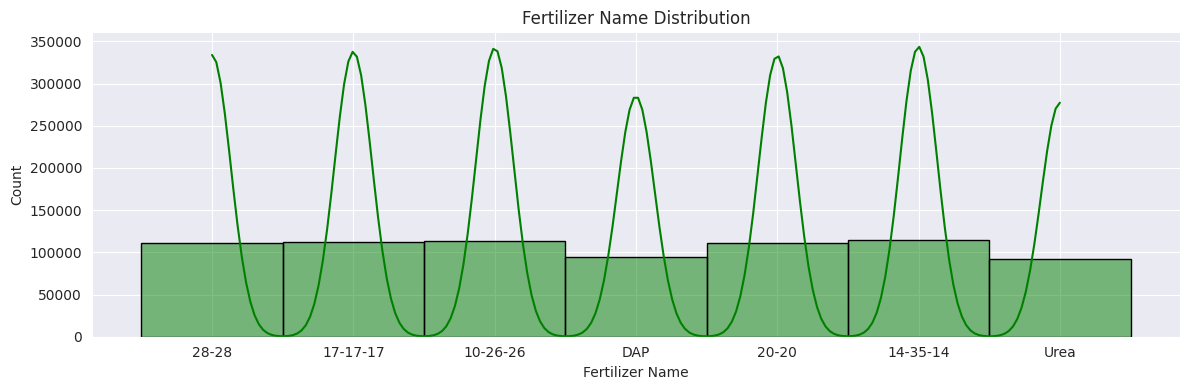

In [11]:
detail_columns(
    fertilizers_train,
    "Fertilizer Name",
    "Fertilizer Name Distribution"
)

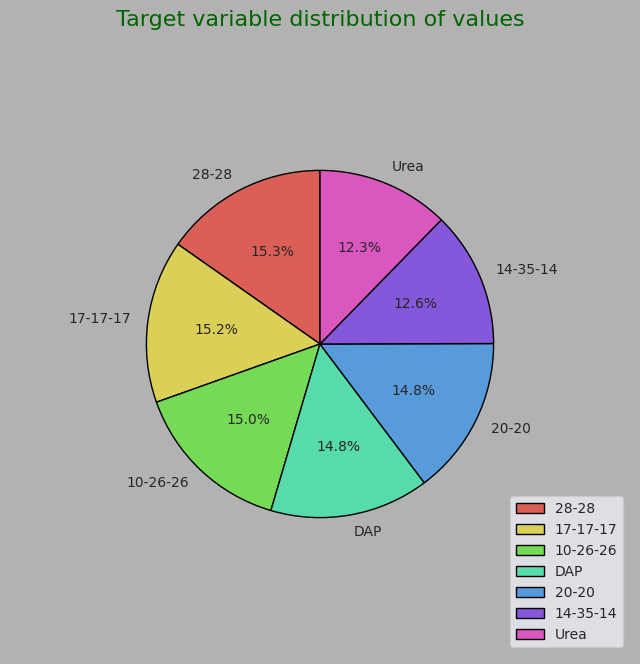

In [12]:
fig,ax = plt.subplots(figsize =(8, 10))
fig.set_facecolor("#b2b2b2")
fertilizer_values = ["28-28", "17-17-17", "10-26-26", "DAP", "20-20", "14-35-14", "Urea"]

ax.pie(
    fertilizers_train["Fertilizer Name"].value_counts(),
    labels=fertilizer_values,
    radius=0.7, 
    startangle=90, 
    autopct= "%1.1f%%",
    colors=sns.color_palette("hls",7),
    wedgeprops={'edgecolor' : "k"}
)

plt.title("Target variable distribution of values", color="darkgreen", fontsize=16)
plt.legend(loc="lower right", labels=fertilizer_values, fontsize=10)
plt.show()

We found a categorical target variable with seven unique values. We found no null or erroneous values. The distribution of values is balanced, with almost the same number of samples per value.

## Temparature

Temperature influences fertilizer selection and application due to its impact on soil processes and nutrient availability. Factors such as soil temperature, the plant's growth stage, and the specific fertilizer type must be considered.

Variable:  Temparature 
Format:  int64 
Number of null values:  0 
Unique values:  14 
Distribution of values: 
 Temparature
27    55228
35    54855
32    54656
30    53867
34    53788
38    53743
36    53725
26    53310
29    53198
33    53178
31    52924
25    52876
28    52431
37    52221
Name: count, dtype: int64


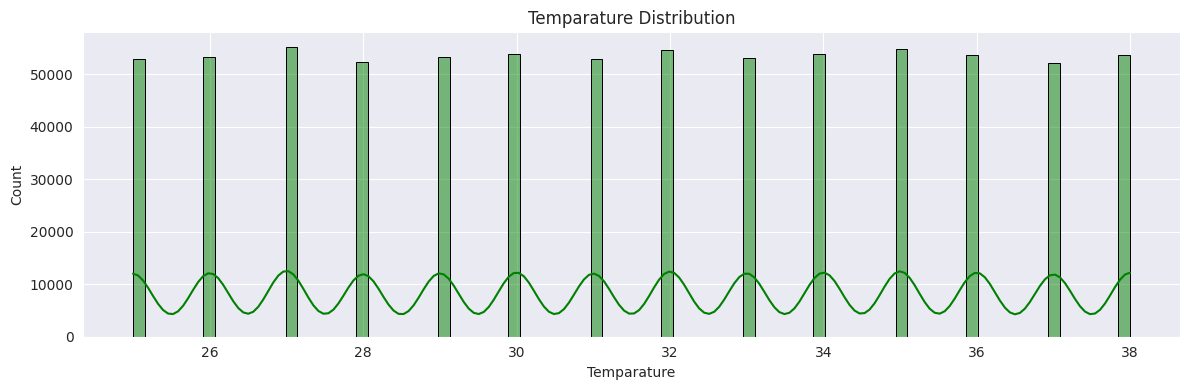

In [13]:
detail_columns(
    fertilizers_train,
    "Temparature",
    "Temparature Distribution"
)

We found no null or erroneous values. The variable has 14 unique values, ranging from 25 to 38 degrees, with an average temperature of around 31.5 degrees. We observed no outliers, with a nearly normal distribution.

## Humidity

Relative humidity is critical in fertilizer selection and management. Each fertilizer has a relative humidity (RH), which is the percentage of relative humidity at which it begins to absorb moisture.
Excessive humidity can cause fertilizers to form lumps or blocks, dissolve and leach nutrients, reducing fertilizer effectiveness and causing losses, and can also affect fertilizer mixability and cause undesirable chemical reactions.

Variable:  Humidity 
Format:  int64 
Number of null values:  0 
Unique values:  23 
Distribution of values: 
 Humidity
70    33745
53    33640
62    33617
71    33525
64    33446
52    33220
66    33197
67    33132
72    33027
61    32771
60    32596
65    32541
51    32530
55    32405
68    32388
57    32342
54    32246
56    31997
50    31946
59    31843
63    31674
69    31371
58    30801
Name: count, dtype: int64


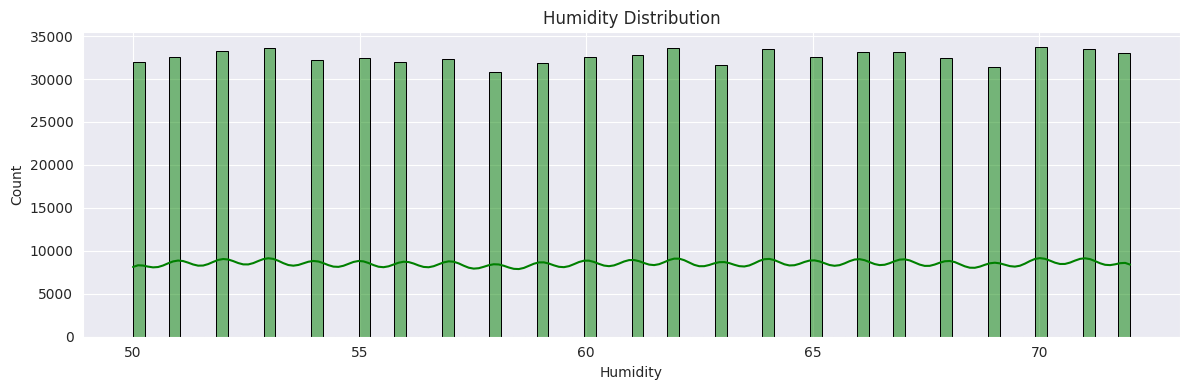

In [14]:
detail_columns(
    fertilizers_train,
    "Humidity",
    "Humidity Distribution"
)

We found a variable with a near-normal distribution, with a mean and median humidity of 61 percent, and a range of values between 50% and 72%. We also observed no extreme values. The variable did not present any null or erroneous data, with a total of 23 distinct values.

## Moisture

Moisture is the presence of a liquid, especially water, often in trace amounts, or water in any state (liquid, solid, or vapor) within a substance. Its measurement can be used in various contexts, including agriculture, construction, and food processing. Can be expressed as a percentage or in other units depending on the context (e.g., grams per cubic meter of air for humidity, moisture content of wood in construction). Essentially, humidity is a measure of moisture content in the atmosphere, particularly when referring to water vapor, while moisture is a broader term encompassing water in various forms (liquid, solid, or gas) present in different substances, including the air.

Variable:  Moisture 
Format:  int64 
Number of null values:  0 
Unique values:  41 
Distribution of values: 
 Moisture
61    19809
48    19386
47    19299
53    19270
46    19180
39    19163
51    19155
58    18867
45    18864
34    18829
52    18791
62    18748
64    18745
43    18700
33    18676
37    18604
57    18585
65    18450
60    18433
35    18290
54    18264
38    18243
49    18226
28    18199
63    18126
26    18123
40    17962
56    17904
29    17856
59    17837
44    17805
41    17700
27    17592
36    17573
55    17524
25    17514
42    17510
32    17386
30    17135
50    17027
31    16650
Name: count, dtype: int64


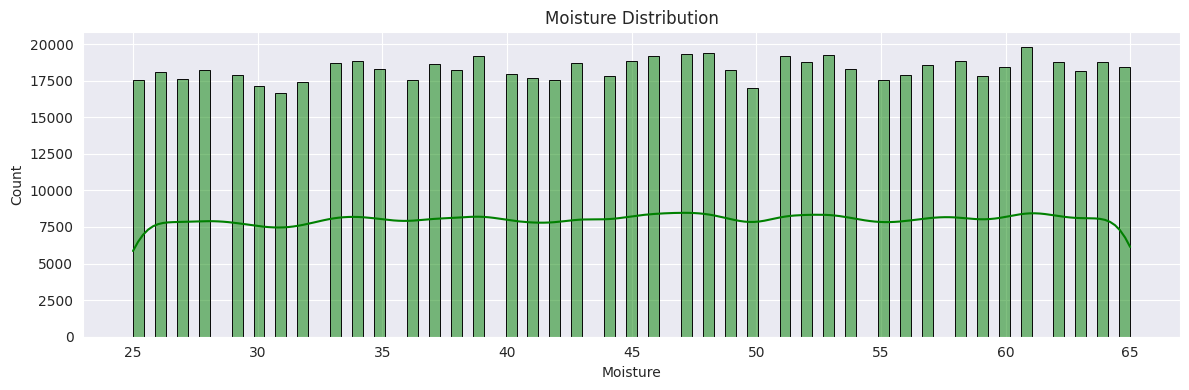

In [15]:
detail_columns(
    fertilizers_train,
    "Moisture",
    "Moisture Distribution"
)

Once again, we find a near-normal distribution, with a mean of 45 on average. The values range from 25 to 65, with no extreme values. The variable has 41 unique values and no null or erroneous data.

## Soil Type

Different soil types significantly influence fertilizer selection and effectiveness, affecting factors such as nutrient retention and availability, and the need for different types of fertilizers. Understanding your soil type helps you choose the right fertilizer for optimal growth. Essentially, soil type determines how fertilizers will interact and how effectively plants will absorb nutrients. Performing a soil test is crucial for determining your soil's specific needs and selecting the most appropriate fertilizer for your crops.

- Sandy Soils: These soils have poor water and nutrient retention, requiring more frequent, smaller fertilizer applications. Slow-release fertilizers and organic matter amendments can be helpful to increase nutrient availability.

- Clay Soils: While clay soils have high nutrient and water retention, they can become compacted, limiting root penetration and nutrient uptake. Proper soil aeration and potentially deeper tillage may be needed.

- Loamy Soils: Loam, with its balanced mix of sand, silt, and clay, is considered ideal for agriculture, providing optimal nutrient retention and availability. Balanced nutrient management plans are generally sufficient for this soil type.

- Red soil: while containing a mixture of clay and sand, is not naturally highly fertile. To improve fertility, organic and inorganic fertilizers are commonly used. Organic fertilizers include green manure, farmyard manure, and crop residues, while inorganic fertilizers can include calcium magnesium phosphate, potassium chloride, and urea.

- Black soils: rich in organic matter and essential nutrients, but can still benefit from appropriate fertilizer selection to optimize their fertility and productivity. Organic fertilizers, particularly manure and compost, are excellent choices for improving soil health and carbon sequestration. Consider also incorporating beneficial microorganisms to enhance nutrient cycling and plant growth.

Variable:  Soil Type 
Format:  object 
Number of null values:  0 
Unique values:  5 
Distribution of values: 
 Soil Type
Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: count, dtype: int64


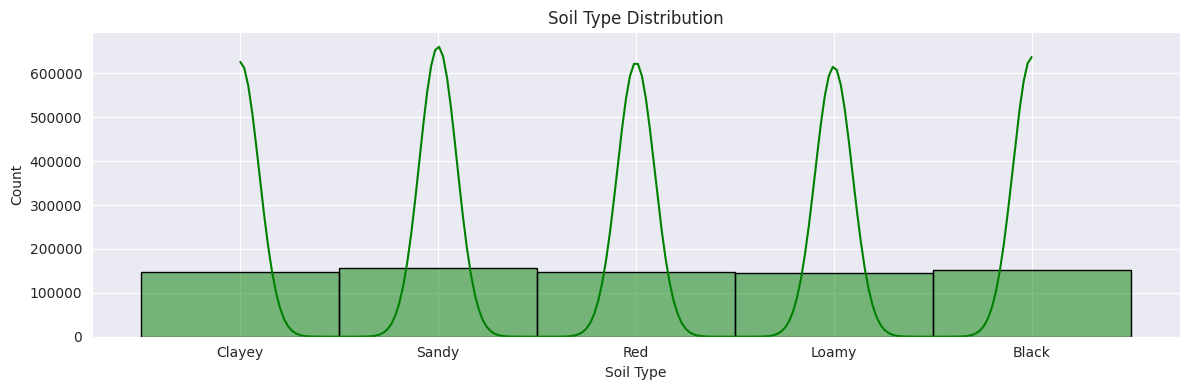

In [16]:
detail_columns(
    fertilizers_train,
    "Soil Type",
    "Soil Type Distribution"
)

We found a categorical variable, with values distributed across five categories representing different soil types. Sandy soil represents the largest number of samples, although in general, the samples are fairly evenly distributed across the five unique values. The variable does not present any null or erroneous data.

## Crop Type

When selecting the right fertilizer for a specific crop, it is important to consider its nutritional needs, soil characteristics, and the desired outcome. Cereal crops, such as wheat, rice, and corn, generally benefit from NPK fertilizers, while legumes, such as lentils and chickpeas, may require phosphate-rich fertilizers. Fruits and vegetables, such as tomatoes and potatoes, often require micronutrient-enriched fertilizers, and oilseeds, such as mustard and sunflower, may require sulfur-based options.

- Cereal Crops (Wheat, Rice, Maize): These crops have a high demand for nitrogen (N) for vegetative growth and phosphorus (P) for root development. NPK fertilizers, like Shriram Supravet, are often recommended to ensure a balanced supply of these nutrients.

- Pulses (Lentils, Chickpeas, Soybeans): Pulses need phosphorus (P) for root nodulation and nitrogen fixation. Phosphate-rich fertilizers and biofertilizers are suitable choices.

- Fruits and Vegetables (Tomatoes, Potatoes, Mangoes): These crops require a variety of micronutrients for optimal fruit quality and disease resistance. Micronutrient-enriched fertilizers like Shriram Ultrazib can be beneficial.

- Oilseeds (Mustard, Groundnut, Sunflower): Sulfur (S) is crucial for oil synthesis in oilseed crops. Sulfur-based fertilizers are often used to ensure adequate sulfur supply.

Variable:  Crop Type 
Format:  object 
Number of null values:  0 
Unique values:  11 
Distribution of values: 
 Crop Type
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: count, dtype: int64


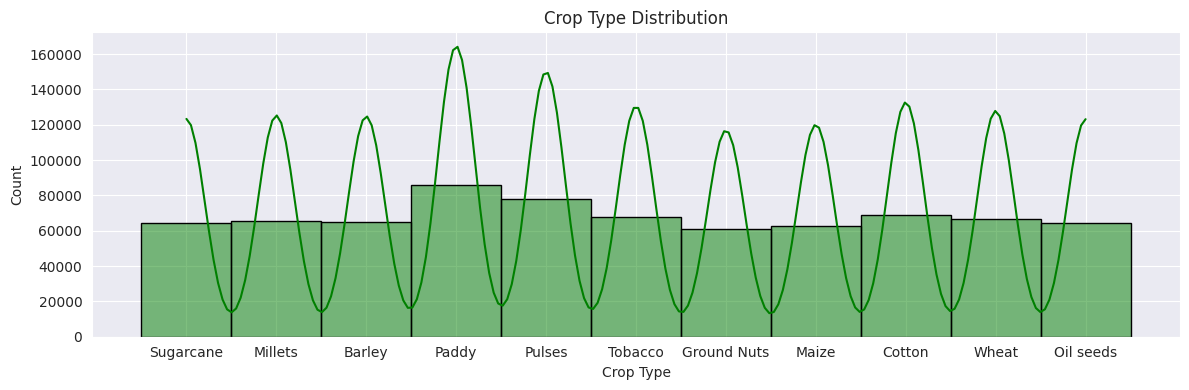

In [17]:
detail_columns(
    fertilizers_train,
    "Crop Type",
    "Crop Type Distribution"
)

We found the second categorical feature, with a distribution of eleven different crop classes, with the 'Paddy' crop having the largest number of samples, followed by 'Pulses'. The other categories contain the same number of samples on average. We found no null or erroneous data present.

## Nitrogen

Nitrogen-rich fertilizers promote rapid vegetative growth and a healthy green color. Different nitrogen sources have different release rates and loss potential, so understanding the needs of plants and soil is crucial. Selecting a fertilizer, the amount, and the form of nitrogen are key factors. Nitrogen measurements are commonly expressed as concentration, using units such as mg/L (milligrams per liter), ppm (parts per million), or mg/kg (milligrams per kilogram), depending on whether the sample is liquid or solid. When measuring nitrogen in water, mg/L is frequently used, while mg/kg is more common for soil or sediment. In some cases, units such as scf (standard cubic feet) or Nm³ (normal cubic meters) may be used to measure the volume of gas, especially when dealing with compressed nitrogen.

Variable:  Nitrogen 
Format:  int64 
Number of null values:  0 
Unique values:  39 
Distribution of values: 
 Nitrogen
25    20484
11    20283
38    20269
26    20177
24    20122
42    19910
27    19843
16    19746
21    19623
18    19578
40    19532
17    19459
35    19435
22    19431
33    19396
37    19320
34    19315
12    19313
19    19304
15    19272
30    19270
6     19149
36    19145
7     19105
29    19061
8     18981
4     18956
41    18865
28    18847
13    18805
14    18769
32    18739
20    18683
39    18573
31    18511
23    18452
9     18332
10    18112
5     17833
Name: count, dtype: int64


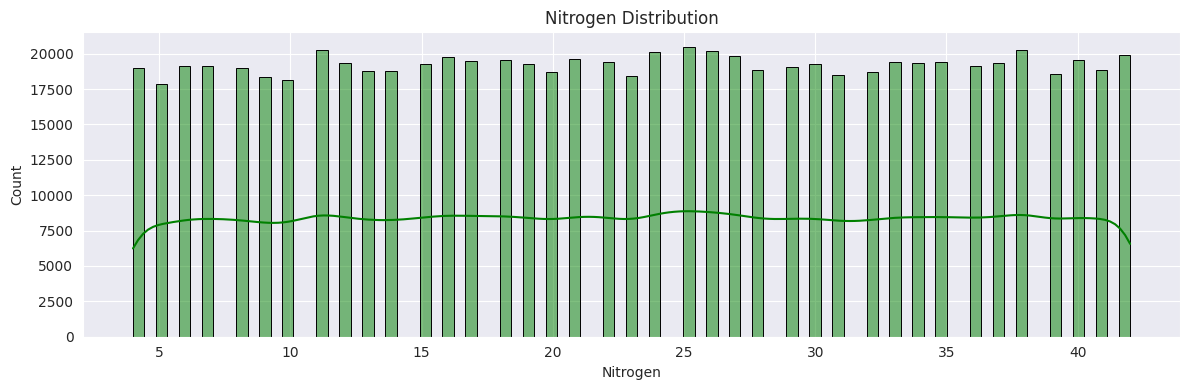

In [18]:
detail_columns(
    fertilizers_train,
    "Nitrogen",
    "Nitrogen Distribution"
)

Once again, we find a nearly normal distribution, with the mean and average within the same value of 23 (assuming milligrams per liter). The values ​​range from 4 to 42, with 39 distinct values, and no outliers. The variable does not present any null or erroneous data.

## Potassium

It is essential for plant health, stress resistance, and crop quality. When choosing a fertilizer, it is important to understand the specific needs of plants and the potassium levels in the soil. In the context of fertilizers, potassium content is typically expressed as K₂O (potassium oxide). While K₂O does not exist as a compound in fertilizer or plants, it is the standard unit used to indicate the relative amount of potassium. Soil and plant tissue tests may indicate potassium as the element K (potassium), but fertilizer recommendations are consistently expressed as K₂O. Potassium is a crucial macronutrient for plants, similar to nitrogen and phosphorus, and plays a vital role in fertilizer selection.

Variable:  Potassium 
Format:  int64 
Number of null values:  0 
Unique values:  20 
Distribution of values: 
 Potassium
0     39060
3     38762
9     38533
14    38292
11    38207
8     38164
15    37997
13    37930
4     37701
16    37691
1     37328
18    37173
6     36953
12    36796
17    36761
10    36747
2     36697
7     36671
19    36583
5     35954
Name: count, dtype: int64


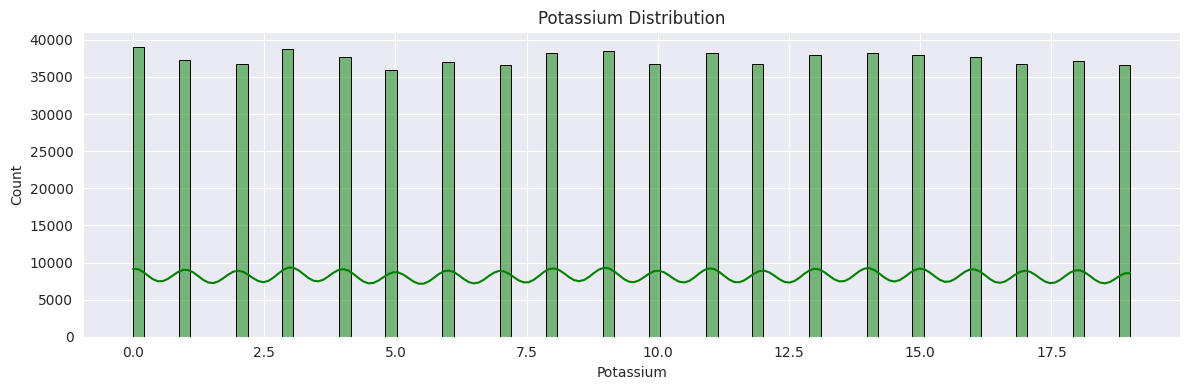

In [19]:
detail_columns(
    fertilizers_train,
    "Potassium",
    "Potassium Distribution"
)

As with all variables, we continued to find a nearly normal distribution, in this case with a mean and average of around 9.0. The values ranged from 0 to 19, and again, we found no extreme values. We found a high presence of zero values, with the largest number of samples being the possible lack of potassium present in some fertilizers. Overall, the values were similar in the number of samples within a short range. No null or erroneous data were detected.

## Phosphorous

When choosing a fertilizer, phosphorus content, often represented by the "P" in NPK (nitrogen, phosphorus, and potassium) ratios, plays a key role in meeting plant needs, especially during the budding and flowering stages. Phosphorus in fertilizer formulations is crucial, particularly for root development, early growth, and flowering. It is measured and labeled as %P₂O₄, which represents phosphate. While fertilizer does not contain pure P₂O₄, this notation is a standard way to indicate the amount of phosphorus present. To obtain the actual percentage of phosphorus, multiply the P₂O₄ percentage by 0.436.

Variable:  Phosphorous 
Format:  int64 
Number of null values:  0 
Unique values:  43 
Distribution of values: 
 Phosphorous
24    19137
22    18633
18    18560
15    18540
39    18385
25    18260
26    18189
40    18009
0     17976
29    17941
17    17900
33    17786
28    17770
9     17761
14    17753
23    17732
21    17644
7     17614
12    17593
4     17490
34    17467
41    17455
27    17442
30    17338
20    17318
35    17246
16    17114
3     17101
42    17097
1     17086
11    17078
37    17001
31    16989
38    16944
10    16914
13    16843
2     16790
5     16775
32    16642
19    16417
36    16215
8     16072
6     15983
Name: count, dtype: int64


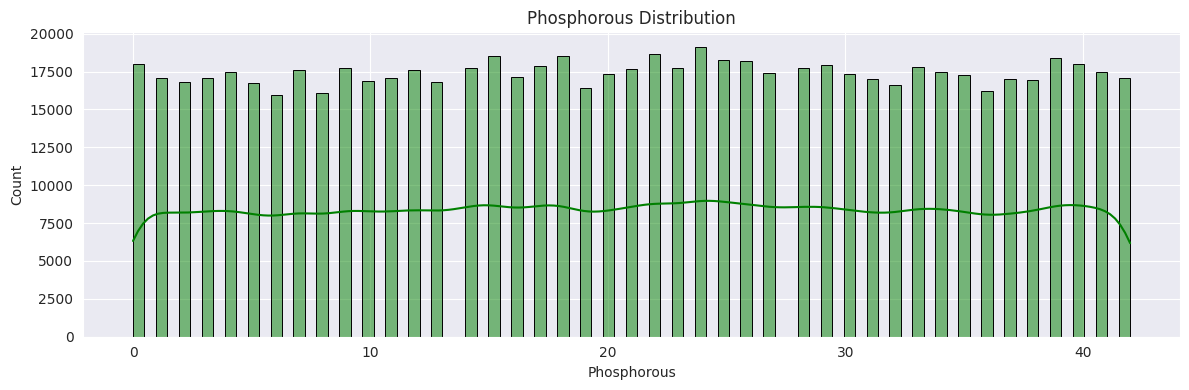

In [20]:
detail_columns(
    fertilizers_train,
    "Phosphorous",
    "Phosphorous Distribution"
)

The same distribution pattern is maintained for the previous variables, with a mean and average of around 21.0. The values are distributed across 43 unique values, within a range of 0.0 to 42.0, with no outliers or extremes. The samples fall within the same range for all values. We found no null or erroneous data.

## Notes

- We did not find any null or erroneous data present in any variable. We will double-check this in the data management process, as well as the possible presence of duplicate data.

- All variables exhibit a near-normal distribution, with no outliers detected at this time. Although we could extend this analysis to corroborate the information with box plots.

- By analyzing not only the content of the variables but also the information they provide and what they cover, we were able to establish certain relationships, such as soil moisture or temperature, as well as with the different types of crops, and with the different elements. A correlation analysis would be important to determine if these linear relationships are present in the data.

- We did not find necessary to perform data cleaning. A feature engineering process could be a next step before asking some interesting questions and exploring the data in more depth.

# Data wrangling

Next, we will perform data Cleaning, if necessary. From our exploratory analysis, we observed that the data does not require extensive clean, as we have not detected any erroneous or null data so far, and we have not observed any extreme values. We will perform a specific check to verify what we saw in the EDA, checking for nulls, duplicates, and outliers.

In [21]:
# We make a copy of the original dataset

fertilizers_new = fertilizers_train.copy()

In [22]:
# We confirm that there is no null values

null_values = pd.DataFrame(
        {f"Null Data" : fertilizers_new.isnull().sum(), 
         "Percentage" : (fertilizers_new.isnull().sum()) / (len(fertilizers_new)) * (100)})

null_values

,Null Data,Percentage
Temparature,0,0.0
Humidity,0,0.0
Moisture,0,0.0
Soil Type,0,0.0
Crop Type,0,0.0
Nitrogen,0,0.0
Potassium,0,0.0
Phosphorous,0,0.0
Fertilizer Name,0,0.0


In [23]:
# We check for duplicate data

print(f"Length: {len(fertilizers_new.duplicated())}")
print(f"Duplicates: {fertilizers_new.duplicated().sum()}")

Length: 750000
Duplicates: 0


We can confirm that the data does not present null values or duplicates.

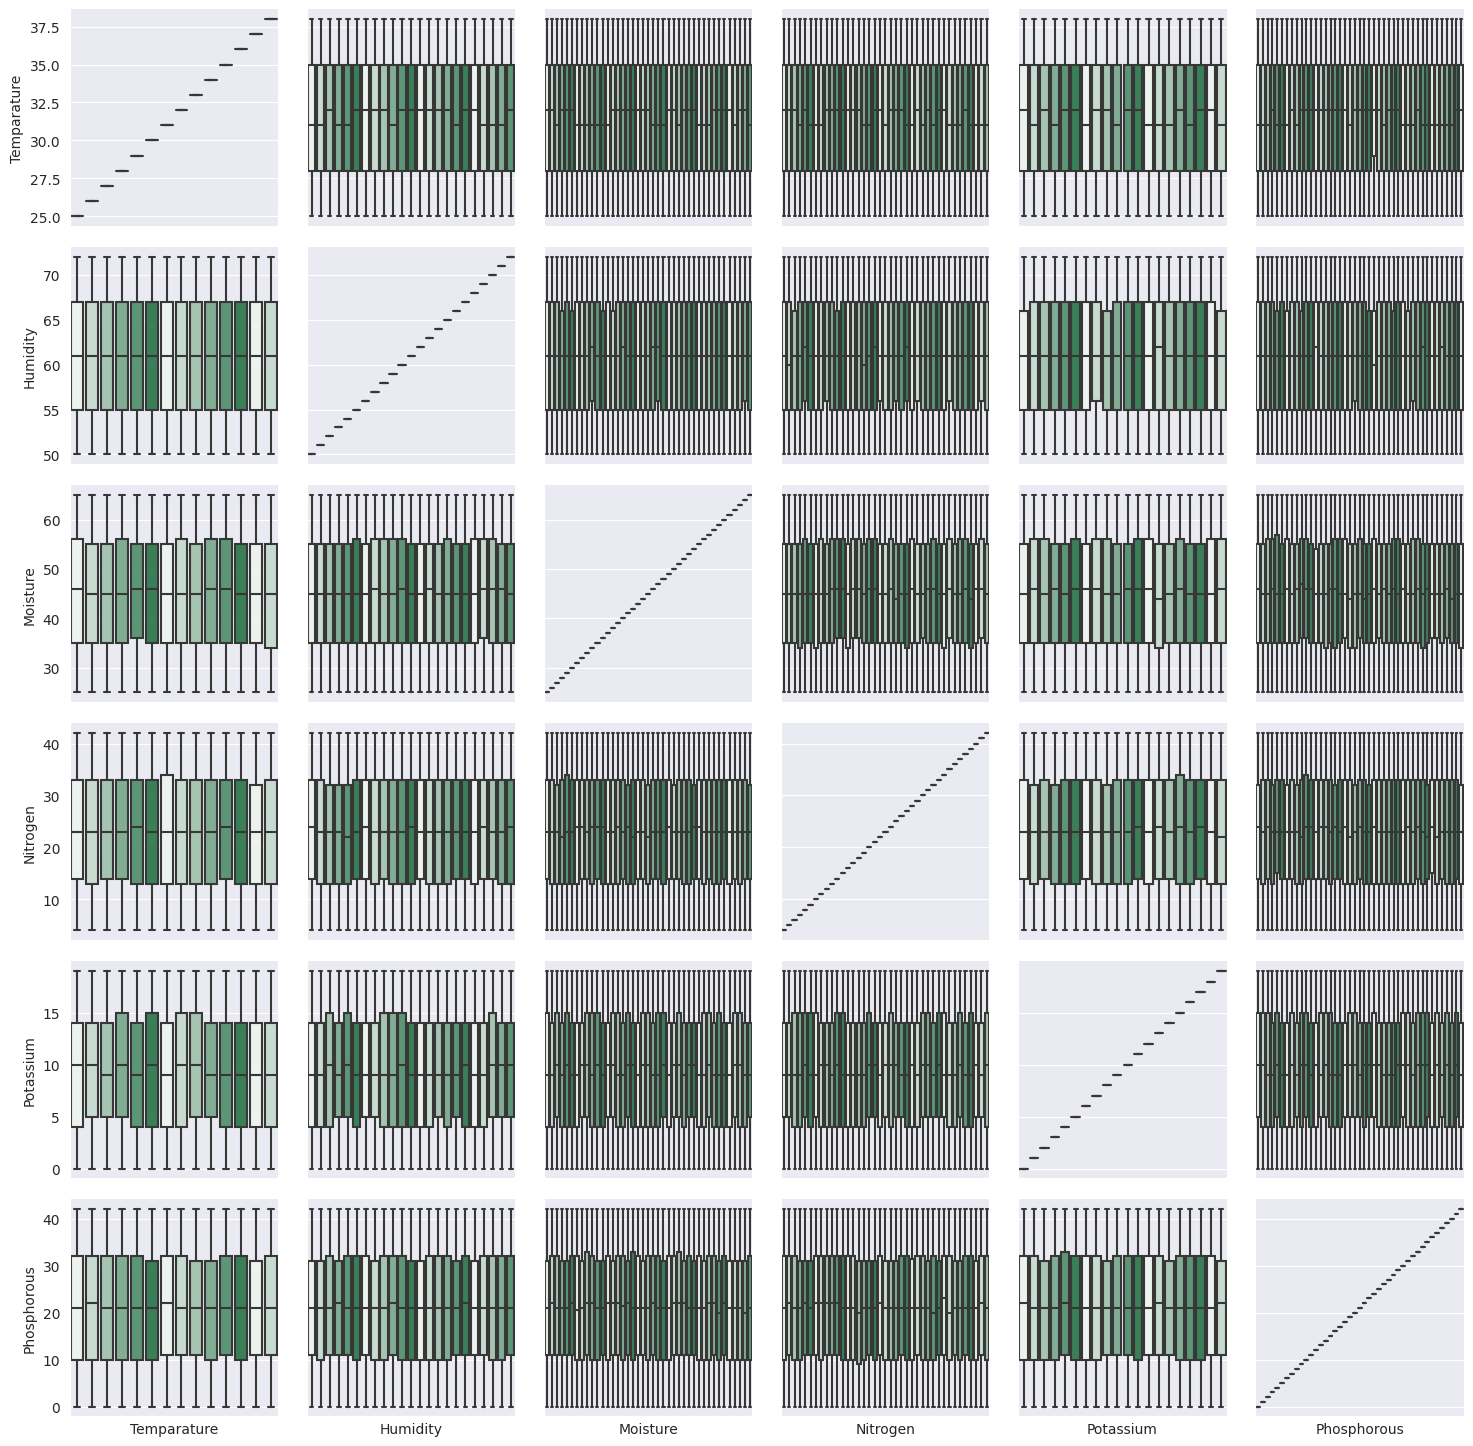

In [24]:
eval_out = sns.PairGrid(fertilizers_new, palette=sns.light_palette("seagreen"))
eval_out.map(sns.boxplot)
eval_out.tick_params(axis="both", labelbottom=False)

In [25]:
# We changed the format for more efficient memory usage

fertilizers_new[fertilizers_new.select_dtypes(["object"]).columns] = (
    fertilizers_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

Regarding outliers, or the presence of extremes in the data, we can corroborate what we observed in the EDA regarding the distribution of each feature. We could apply an adjustment to all variables based on the 95th percentile and the respective 5th percentile, but we'll leave the data as is and proceed to ask some interesting questions to explore the data in more depth.

# Questions of Interest

We asked some interesting questions to understand the data in more depth, as well as how the variables are related, and what information they contain.

In [26]:
# Establishing the seaborn aesthetic

sns.set_style("dark")

- What elements does each fertilizer present in the data contain?
- Which fertilizer contains all the elements present in the data?

In [27]:
fer_n = fertilizers_new.pivot(columns="Fertilizer Name", values="Nitrogen")
fer_k = fertilizers_new.pivot(columns="Fertilizer Name", values="Potassium")
fer_p = fertilizers_new.pivot(columns="Fertilizer Name", values="Phosphorous")

In [28]:
# We analyze the nitrogen values

fer_n.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,23.202648,23.083453,23.205215,23.008441,23.013431,23.155977,22.972107
std,11.244531,11.106016,11.191768,11.253946,11.231735,11.274307,11.219700
min,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
25%,14.000000,14.000000,14.000000,13.000000,13.000000,13.000000,13.000000
50%,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
75%,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
max,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000


Nitrogen can be found in all fertilizers and samples, representing the constant or essential element in the composition of all fertilizers.

In [29]:
# We analyze the potassium values

fer_k.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,9.555138,9.484568,9.523899,9.590329,9.478220,9.252878,9.417323
std,5.787646,5.728002,5.777925,5.812375,5.715701,5.768208,5.763855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000
50%,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,9.000000
75%,15.000000,14.000000,15.000000,15.000000,14.000000,14.000000,14.000000
max,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000


As for potassium, we can see that it is not an element present in all samples, which means that it may not be necessary or correct to use in all soils or crops, unless we consider these values to be erroneous.

In [30]:
# We analyze the phosphorus values

fer_p.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,20.980885,21.410221,21.053934,21.110633,21.024821,20.956051,20.926666
std,12.388746,12.375613,12.340902,12.320987,12.397456,12.293027,12.284100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,11.000000,11.000000,10.000000,11.000000,10.000000
50%,21.000000,22.000000,21.000000,21.000000,21.000000,21.000000,21.000000
75%,32.000000,32.000000,32.000000,31.000000,32.000000,31.000000,32.000000
max,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000


We again find what we observed with potassium. Phosphorus also presents samples where it is absent. We can also observe maximum and average values similar to those of nitrogen.

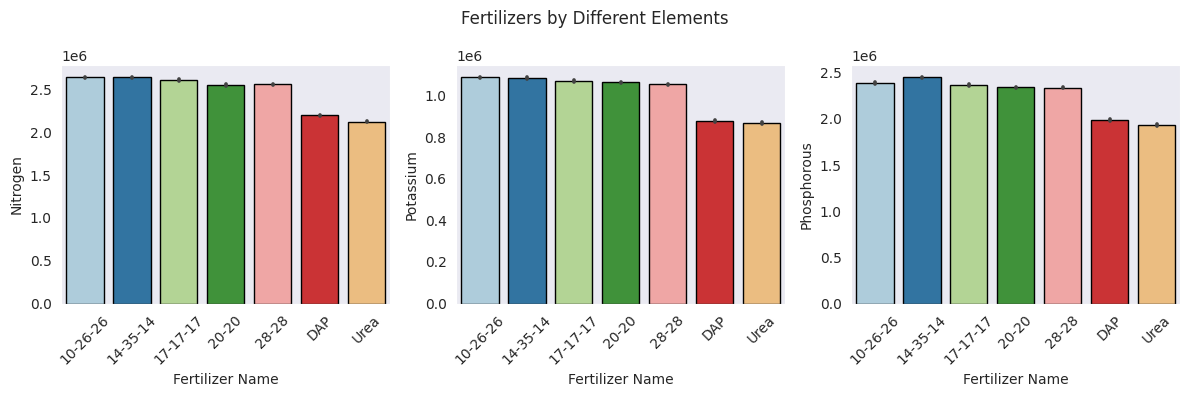

In [31]:
# We analyze fertilizers by element

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.barplot(
    data=fertilizers_new, 
    x="Fertilizer Name", 
    y="Nitrogen", 
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
).tick_params(axis='x', labelrotation=45)
sns.barplot(
    data=fertilizers_new, 
    x="Fertilizer Name", 
    y="Potassium", 
    estimator="sum", 
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
).tick_params(axis='x', labelrotation=45)
sns.barplot(
    data=fertilizers_new, 
    x="Fertilizer Name", 
    y="Phosphorous", 
    estimator="sum", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[2]
).tick_params(axis='x', labelrotation=45)
plt.suptitle(t="Fertilizers by Different Elements")
plt.tight_layout()
plt.show()

We can clearly identify all the elements present in the fertilizers. The differences in DAP and Urea may be due to the number of samples. We observed values of 0 present for potassium and phosphorus, which implies that each fertilizer may have different combinations depending on the sample. This could be due to other variables, such as the soil or crop type, which could be logical, or we could be faced with possible erroneous values. Analyzing other variables can provide further insights into the topic.

- What is the most commonly used fertilizer for each type of soil?
- What fertilizer is most commonly used for each type of crop?

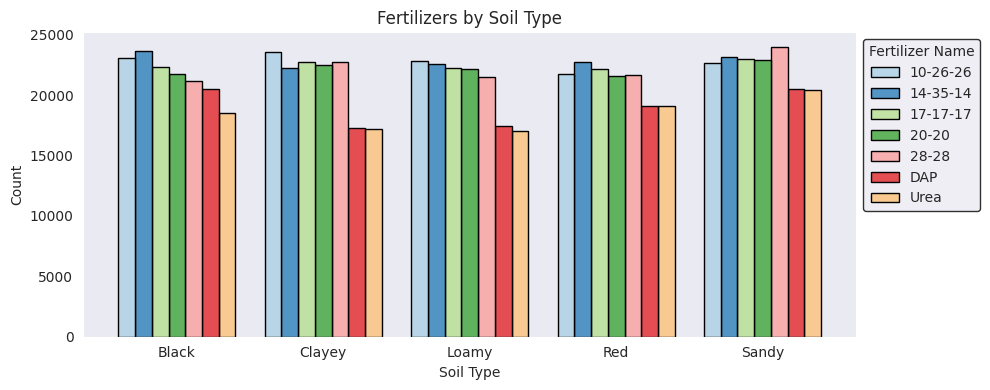

In [32]:
# We analyze the fertilizers by soil type

fig, axes = plt.subplots(figsize=(10, 4))

sns.histplot(
    data=fertilizers_new, 
    x="Soil Type",
    hue="Fertilizer Name",
    multiple="dodge", 
    shrink=.8,
    edgecolor="k",
    palette="Paired",
    ax=axes
)

sns.move_legend(
    axes, "upper left", 
    bbox_to_anchor=(1, 1), 
    edgecolor="black"
)

plt.title("Fertilizers by Soil Type")
plt.tight_layout()
plt.show()

In greater or lesser quantities, all fertilizers are used in each soil type. In the case of black soil, "14-35-14" is the most commonly used, followed by "10-26-26," which is most commonly used for clay or loamy soils. For red soil, usage is somewhat general across all types, with "14-35-14" having slightly more samples. Finally, in sandy soils, the use of "28-28" predominates.

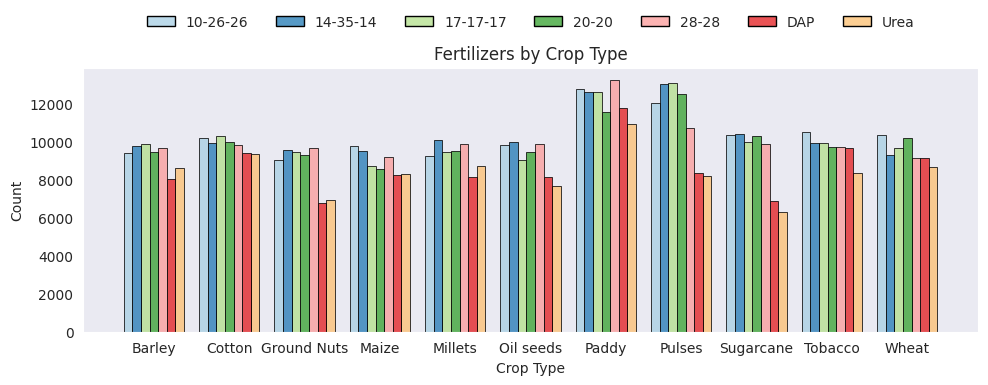

In [33]:
# We analyze the fertilizers by crop type

fig, axes = plt.subplots(figsize=(10, 4))

sns.histplot(
    data=fertilizers_new, 
    x="Crop Type",
    hue="Fertilizer Name", 
    multiple="dodge", 
    shrink=.8,
    edgecolor="k",
    palette="Paired",
    ax=axes
)
sns.move_legend(
    axes, "lower center",
    bbox_to_anchor=(.5, 1.1), 
    ncol=7, 
    title=None, 
    frameon=False,
)

plt.title("Fertilizers by Crop Type")
plt.tight_layout()
plt.show()

Rice and legume crops were found to have the largest number of samples. Again, as with the soil types, all fertilizers were present in the crops, to a greater or lesser extent, with DAP and urea being the least used overall. A soil analysis by crop and the different fertilizers will provide further information on the subject.

- What types of soil predominate in different crops?
- How are fertilizers distributed, taking into account the soil and the crop?

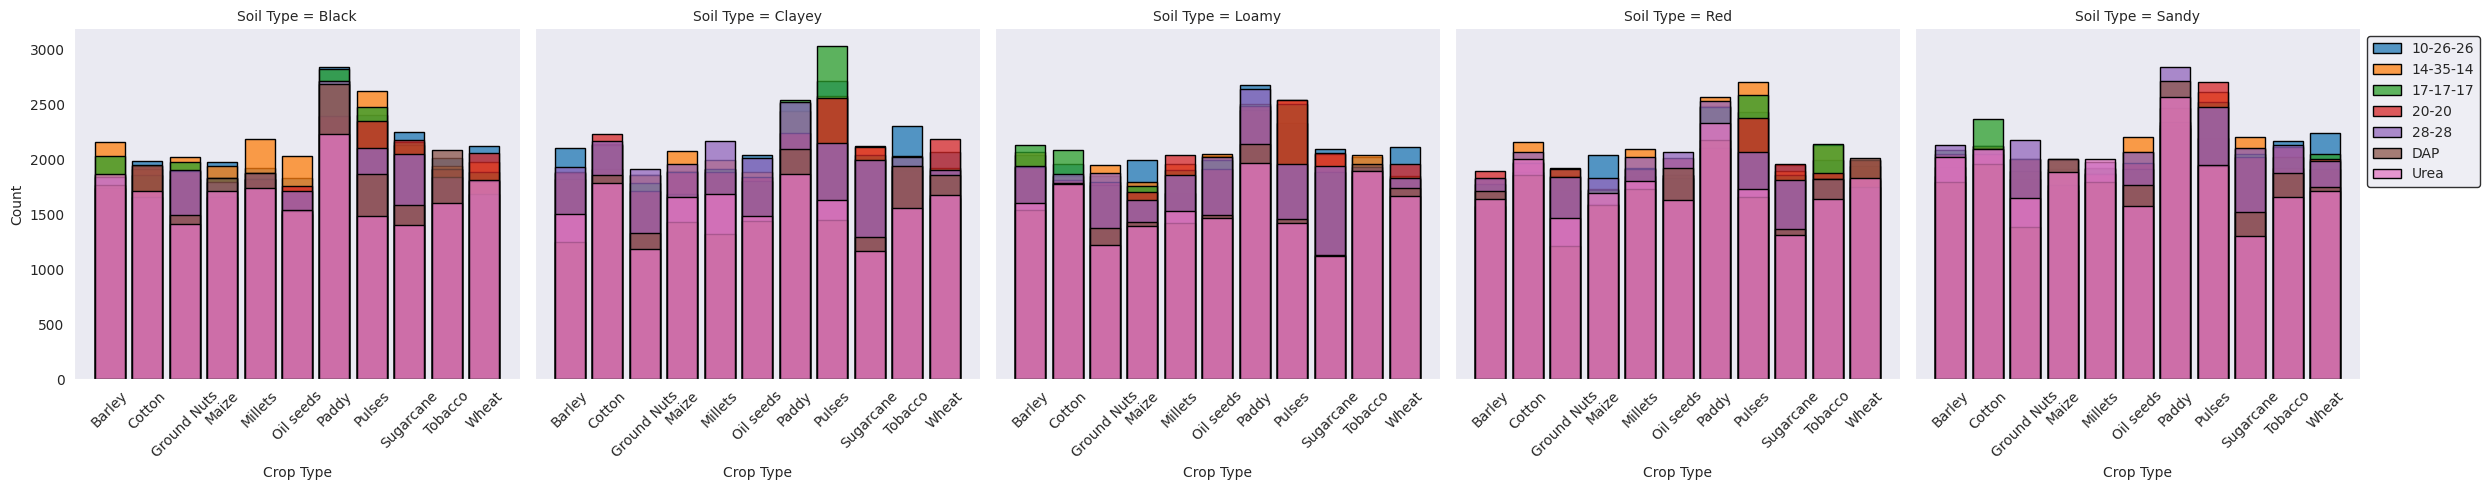

In [34]:
# We analyze the fertilizers by Crop & Soil type

graph = sns.FacetGrid(
    fertilizers_new, 
    col="Soil Type", 
    hue="Fertilizer Name", 
    height=5, aspect=1
)
graph.map(
    sns.histplot, 
    "Crop Type", 
    palette="Paired",  
    shrink=.8,
    edgecolor="k"
)
graph.set_xticklabels(rotation=45)

plt.legend(loc="best", bbox_to_anchor=(1, 1), edgecolor="black")
plt.tight_layout()
plt.show()

We wouldn't be gaining much insight from this analysis or the graph. This may be due to how the information was collected or generated. A more in-depth study of the different soil types and crops is necessary to understand if what we're seeing is accurate, since we found all types of crops present in each soil. Regarding fertilizers, we didn't observe any more information than previously obtained, nor did we observe any information regarding the other variables. Rice and legume crops were the predominant crops in each soil, which may be due to the number of samples. We will continue analyzing the temperatures and humidity percentages.

- What is the average temperature or humidity, considering the soil and the crop?
- What temperature or humidity values do we find, considering each type of fertilizer?

In [35]:
soil_tem = fertilizers_new.pivot(columns="Soil Type", values="Temparature")
soil_hum = fertilizers_new.pivot(columns="Soil Type", values="Humidity")
soil_moi = fertilizers_new.pivot(columns="Soil Type", values="Moisture")

In [36]:
soil_tem.describe().T

,count,mean,std,min,25%,50%,75%,max
Soil Type,,,,,,,,
Black,150956.0,31.583435,4.002604,25.0,28.0,32.0,35.0,38.0
Clayey,148382.0,31.528838,4.025090,25.0,28.0,32.0,35.0,38.0
Loamy,145850.0,31.397669,4.000118,25.0,28.0,31.0,35.0,38.0
Red,148102.0,31.532214,4.061254,25.0,28.0,32.0,35.0,38.0
Sandy,156710.0,31.474182,4.035543,25.0,28.0,32.0,35.0,38.0


In [37]:
soil_hum.describe().T

,count,mean,std,min,25%,50%,75%,max
Soil Type,,,,,,,,
Black,150956.0,61.063204,6.633974,50.0,55.0,61.0,67.0,72.0
Clayey,148382.0,61.000243,6.658968,50.0,55.0,61.0,67.0,72.0
Loamy,145850.0,60.981454,6.666918,50.0,55.0,61.0,67.0,72.0
Red,148102.0,60.980919,6.666066,50.0,55.0,61.0,67.0,72.0
Sandy,156710.0,61.160411,6.613181,50.0,55.0,61.0,67.0,72.0


In [38]:
soil_moi.describe().T

,count,mean,std,min,25%,50%,75%,max
Soil Type,,,,,,,,
Black,150956.0,45.308149,11.772224,25.0,35.0,46.0,55.0,65.0
Clayey,148382.0,45.158301,11.730268,25.0,35.0,45.0,55.0,65.0
Loamy,145850.0,45.122804,11.834852,25.0,35.0,45.0,55.0,65.0
Red,148102.0,45.212928,11.787751,25.0,35.0,45.0,55.0,65.0
Sandy,156710.0,45.119061,11.844823,25.0,35.0,45.0,55.0,65.0


We can find no differences in overall values across soil types, taking into account climate, in terms of minimums, maximums, average values, and percentiles. We can only observe a very small difference in the mean. We found an average temperature of 31 degrees, a humidity percentage of 61% and 45% moisture.

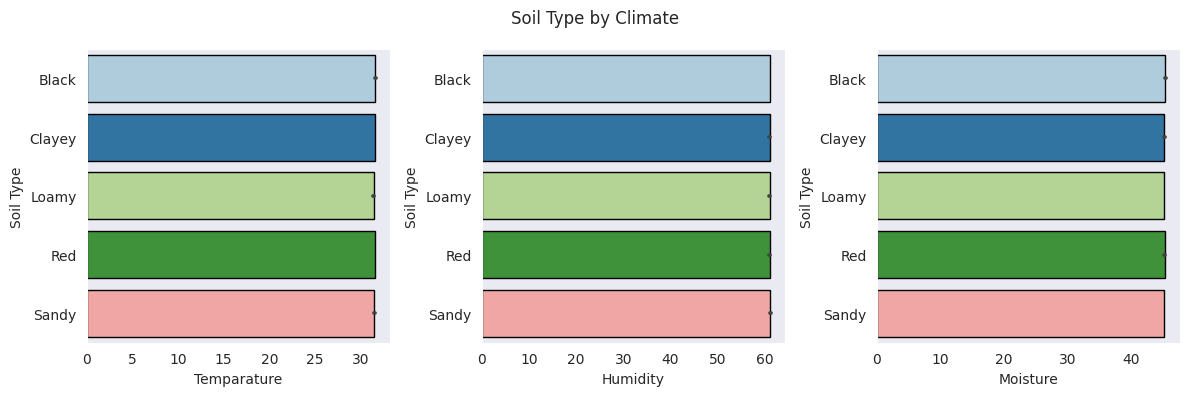

In [39]:
# We analyze Soil Type by Climate

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.barplot(
    data=fertilizers_new, 
    x="Temparature",
    y="Soil Type", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.barplot(
    data=fertilizers_new, 
    x="Humidity", 
    y="Soil Type", 
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
sns.barplot(
    data=fertilizers_new, 
    x="Moisture",
    y="Soil Type",  
    edgecolor="k", 
    palette="Paired",
    ax=axes[2]
)

plt.suptitle(t="Soil Type by Climate")
plt.tight_layout()
plt.show()

By observing and analyzing the graph, we can confirm that there is almost no difference, if any, in soil types by climate. This may be due to the data.

In [40]:
crop_tem = fertilizers_new.pivot(columns="Crop Type", values="Temparature")
crop_hum = fertilizers_new.pivot(columns="Crop Type", values="Humidity")
crop_moi = fertilizers_new.pivot(columns="Crop Type", values="Moisture")

In [41]:
crop_tem.describe()

Crop Type,Barley,Cotton,Ground Nuts,Maize,Millets,Oil seeds,Paddy,Pulses,Sugarcane,Tobacco,Wheat
count,65045.000000,69171.000000,60909.000000,62569.000000,65291.000000,64184.000000,85754.000000,78180.000000,64269.000000,68000.000000,66628.000000
mean,31.498194,31.490827,31.581408,31.554987,31.565805,31.530631,31.527101,31.424111,31.474941,31.442471,31.468422
std,4.002753,3.990108,3.985912,4.027779,4.050164,4.015336,4.065536,4.026811,4.070749,4.010495,4.019514
min,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
25%,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
50%,32.000000,31.000000,32.000000,32.000000,32.000000,32.000000,32.000000,31.000000,31.000000,31.000000,32.000000
75%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
max,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


In [42]:
crop_hum.describe()

Crop Type,Barley,Cotton,Ground Nuts,Maize,Millets,Oil seeds,Paddy,Pulses,Sugarcane,Tobacco,Wheat
count,65045.000000,69171.000000,60909.000000,62569.000000,65291.000000,64184.000000,85754.000000,78180.000000,64269.000000,68000.000000,66628.000000
mean,61.082097,60.947738,61.077115,60.945724,61.152303,60.960333,61.021713,61.093963,60.946755,61.022588,61.171670
std,6.684280,6.622476,6.619633,6.613636,6.667163,6.637766,6.647491,6.627226,6.645480,6.722279,6.631127
min,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
25%,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
50%,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
75%,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
max,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000


In [43]:
crop_moi.describe()

Crop Type,Barley,Cotton,Ground Nuts,Maize,Millets,Oil seeds,Paddy,Pulses,Sugarcane,Tobacco,Wheat
count,65045.000000,69171.000000,60909.000000,62569.000000,65291.000000,64184.000000,85754.000000,78180.000000,64269.000000,68000.000000,66628.000000
mean,44.976216,45.271516,45.339654,45.336077,45.132254,45.044762,45.422977,45.353697,45.101464,44.985941,44.972429
std,11.706903,11.808094,11.862629,11.649212,11.859315,11.864573,11.907852,11.780073,11.685852,11.805348,11.759467
min,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
25%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
50%,45.000000,45.000000,46.000000,46.000000,45.000000,45.000000,45.000000,46.000000,45.000000,45.000000,45.000000
75%,55.000000,55.000000,56.000000,55.000000,55.000000,55.000000,56.000000,55.000000,55.000000,55.000000,55.000000
max,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000


Again, we find the same thing present in the previous analysis regarding soil. We see no differences, except in the averages, in the climate for different crops. We found an average temperature of 31 degrees, a humidity percentage of 60-61% and 45% moisture.

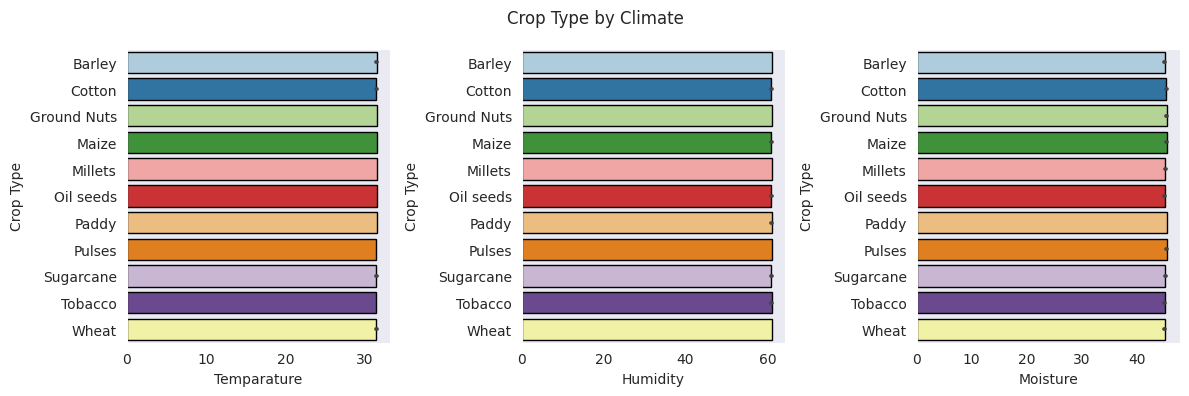

In [44]:
# We analyze Crop Type by Climate

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.barplot(
    data=fertilizers_new, 
    x="Temparature",
    y="Crop Type", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.barplot(
    data=fertilizers_new, 
    x="Humidity", 
    y="Crop Type", 
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
sns.barplot(
    data=fertilizers_new, 
    x="Moisture",
    y="Crop Type",  
    edgecolor="k", 
    palette="Paired",
    ax=axes[2]
)

plt.suptitle(t="Crop Type by Climate")
plt.tight_layout()
plt.show()

Analyzing the graph, we can corroborate what was found in the statistical analysis of crops by climate. We confirm the lack of differences in the values. Again, this may be due to the data itself.

In [45]:
fer_tem = fertilizers_new.pivot(columns="Fertilizer Name", values="Temparature")
fer_hum = fertilizers_new.pivot(columns="Fertilizer Name", values="Humidity")
fer_moi = fertilizers_new.pivot(columns="Fertilizer Name", values="Moisture")

In [46]:
fer_tem.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,31.470589,31.543247,31.463803,31.514406,31.518973,31.508065,31.507296
std,4.038993,4.001384,4.030426,4.025341,4.029370,4.051078,4.001744
min,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
25%,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
50%,32.000000,32.000000,31.000000,31.000000,32.000000,32.000000,32.000000
75%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
max,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000


In [47]:
fer_hum.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,60.937043,60.962669,60.998755,61.104230,61.013179,61.155703,61.140527
std,6.640019,6.641917,6.612568,6.661199,6.654917,6.674935,6.650299
min,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
25%,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
50%,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
75%,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
max,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000


In [48]:
fer_moi.describe()

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
count,113887.000000,114436.000000,112453.000000,110889.000000,111158.000000,94860.000000,92317.000000
mean,45.075856,45.100047,44.740345,45.316713,45.500297,45.261944,45.342743
std,11.786084,11.786555,11.760048,11.769782,11.853618,11.858084,11.731911
min,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
25%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
50%,45.000000,45.000000,45.000000,45.000000,46.000000,46.000000,46.000000
75%,55.000000,55.000000,55.000000,55.000000,56.000000,55.000000,56.000000
max,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000


Once again, we find the same constant equality of values across all climate-related variables, as we had already observed in comparison with soil or crops. We can even observe the same averages. The only small amount of information we can define is a degree of difference in the median of some fertilizers, an a median difference in moisture.

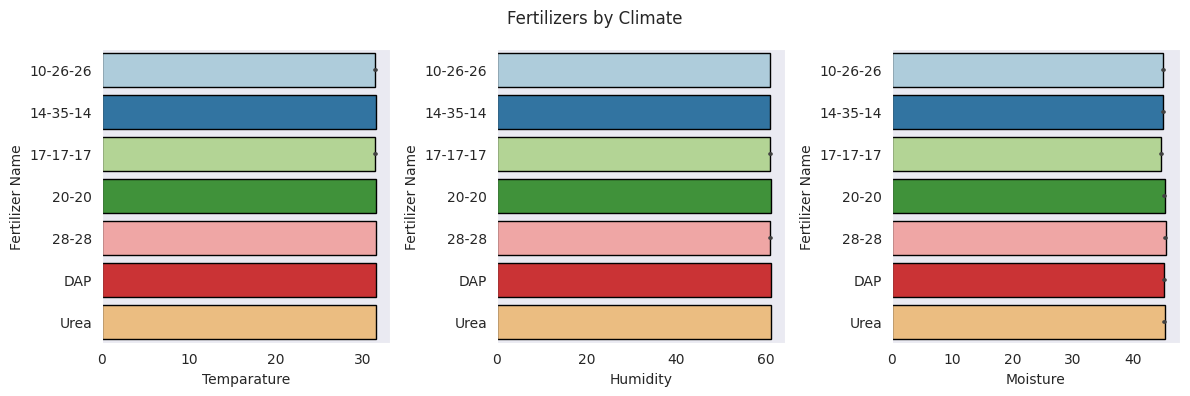

In [49]:
# We analyze fertilizers by Climate

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.barplot(
    data=fertilizers_new, 
    x="Temparature",
    y="Fertilizer Name", 
    edgecolor="k", 
    palette="Paired",
    ax=axes[0]
)
sns.barplot(
    data=fertilizers_new, 
    x="Humidity", 
    y="Fertilizer Name", 
    edgecolor="k",
    palette="Paired",
    ax=axes[1]
)
sns.barplot(
    data=fertilizers_new, 
    x="Moisture",
    y="Fertilizer Name",  
    edgecolor="k", 
    palette="Paired",
    ax=axes[2]
)

plt.suptitle(t="Fertilizers by Climate")
plt.tight_layout()
plt.show()

The graph corroborates what was analyzed and found in the statistical analysis. We were unable to gain much insight into the issues raised. We will leave the more in-depth analysis of the data at this point, in order to perform preprocessing.

# Data Preprocessing

We'll begin preprocessing the data so we can then begin model selection. We'll perform some feature engineering. We'll apply an encoder to the categorical variables and another tool to the target variable, then scale the data where necessary.

In [50]:
fertilizers_end = fertilizers_new.copy()

In [51]:
fertilizers_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Temparature      750000 non-null  int64   
 1   Humidity         750000 non-null  int64   
 2   Moisture         750000 non-null  int64   
 3   Soil Type        750000 non-null  category
 4   Crop Type        750000 non-null  category
 5   Nitrogen         750000 non-null  int64   
 6   Potassium        750000 non-null  int64   
 7   Phosphorous      750000 non-null  int64   
 8   Fertilizer Name  750000 non-null  category
dtypes: category(3), int64(6)
memory usage: 42.2 MB


## Feature Engineering

For our first approach, we won't expand this section, in order to obtain a preliminary result for evaluating the original variables. We'll simply create a few variables to accompany the initial data and expand the number of features.

In [52]:
# We separate the climate variables into bins

bins_tem = [0.0, 29.0, 33.0, 39.0]
bins_hum = [0.0, 57.0, 65.0, 73.0]
bins_moi = [0.0, 36.0, 51.0, 66.0]

# Specify bin labels

labels_climate = ["Low", "Medium", "High"]

# We create the new features

fertilizers_end["Temparature_Bins"] = pd.cut(fertilizers_end["Temparature"], bins_tem, labels=labels_climate)
fertilizers_end["Humidity_Bins"] = pd.cut(fertilizers_end["Humidity"], bins_hum, labels=labels_climate)
fertilizers_end["Moisture_Bins"] = pd.cut(fertilizers_end["Moisture"], bins_moi, labels=labels_climate)

# We separate the elements variables into bins

bins_n = [0.0, 15.0, 30.0, 43.0]
bins_k = [-0.1, 6.0, 12.0, 20.0]
bins_p = [-0.1, 15.0, 30.0, 43.0]

# Specify bin labels

labels_elements = ["Small", "Medium", "Large"]

# We create the new features

fertilizers_end["Nitrogen_Bins"] = pd.cut(fertilizers_end["Nitrogen"], bins_n, labels=labels_elements)
fertilizers_end["Potassium_Bins"] = pd.cut(fertilizers_end["Potassium"], bins_k, labels=labels_elements)
fertilizers_end["Phosphorous_Bins"] = pd.cut(fertilizers_end["Phosphorous"], bins_p, labels=labels_elements)

In [53]:
# We review the new variables

fertilizers_end.describe(exclude = np.number).T

,count,unique,top,freq
Soil Type,750000,5,Sandy,156710
Crop Type,750000,11,Paddy,85754
Fertilizer Name,750000,7,14-35-14,114436
Temparature_Bins,750000,3,High,268332
Humidity_Bins,750000,3,Low,260326
Moisture_Bins,750000,3,Medium,276824
Nitrogen_Bins,750000,3,Medium,292080
Potassium_Bins,750000,3,Small,262455
Phosphorous_Bins,750000,3,Small,275369


In [54]:
# We check that we have not generated null or duplicate data

print(f"Duplicate data: {fertilizers_end.duplicated().sum()}")
print(fertilizers_end.isnull().sum())

Duplicate data: 0
Temparature         0
Humidity            0
Moisture            0
Soil Type           0
Crop Type           0
Nitrogen            0
Potassium           0
Phosphorous         0
Fertilizer Name     0
Temparature_Bins    0
Humidity_Bins       0
Moisture_Bins       0
Nitrogen_Bins       0
Potassium_Bins      0
Phosphorous_Bins    0
dtype: int64


We've created six new variables from the numerical features. We grouped the values by bins, and after mapping these new features, we'll analyze their distribution. We could have created and mapped the new features directly, passing numerical values to the labels, and using '.astype("int")' or some different method to create the features, but we're doing it this way to go through all the processes and allow for exploratory analysis of the new variables if desired. There is still more feature engineering to be done, such as transformations to numeric variables. Next, we'll encode the data where necessary.

## Encoding

We'll start by encoding the target variable, using LabelEncoder. For the rest of the original categorical variables, we'll use OneHotEncoder. We'll map the created features, although OrdinalEcoder could be applied with the 'categories' parameter specified. In addition, we will analyze the correlation of the features.

In [55]:
# We apply LabelEncoder to the target variable

le = LabelEncoder()

fertilizers_end["Fertilizer Name"] = le.fit_transform(fertilizers_end["Fertilizer Name"])

In [56]:
# We create a df with the categorical variables to encode

cat_cols = fertilizers_end[["Soil Type", "Crop Type"]]
rest_cols = fertilizers_end.drop(columns=["Soil Type", "Crop Type"])

# We apply OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop="if_binary").set_output(transform="pandas")
cat_enc = encoder.fit_transform(cat_cols)

# We join the resulting dataframes

df_encoded = pd.concat([rest_cols, cat_enc], axis=1)

In [57]:
# We create a useful function

def mapper(data, column, order):
    
    data[column] = data[column].map(order)
    data[column] = data[column].astype("float64")

    print(data[column].value_counts())

In [58]:
# We map the variables and change the format

climate_order = {"Low" : 0, "Medium" : 1, "High" : 2}
elements_order = {"Small" : 0, "Medium" : 1, "Large" : 2}

mapper(df_encoded, "Temparature_Bins", climate_order)
mapper(df_encoded, "Humidity_Bins", climate_order)
mapper(df_encoded, "Moisture_Bins", climate_order)
mapper(df_encoded, "Nitrogen_Bins", elements_order)
mapper(df_encoded, "Potassium_Bins", elements_order)
mapper(df_encoded, "Phosphorous_Bins", elements_order)

Temparature_Bins
2.0    268332
0.0    267043
1.0    214625
Name: count, dtype: int64
Humidity_Bins
0.0    260326
1.0    259289
2.0    230385
Name: count, dtype: int64
Moisture_Bins
1.0    276824
2.0    259353
0.0    213823
Name: count, dtype: int64
Nitrogen_Bins
1.0    292080
2.0    231010
0.0    226910
Name: count, dtype: int64
Potassium_Bins
0.0    262455
2.0    262427
1.0    225118
Name: count, dtype: int64
Phosphorous_Bins
0.0    275369
1.0    267395
2.0    207236
Name: count, dtype: int64


In [59]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temparature            750000 non-null  int64  
 1   Humidity               750000 non-null  int64  
 2   Moisture               750000 non-null  int64  
 3   Nitrogen               750000 non-null  int64  
 4   Potassium              750000 non-null  int64  
 5   Phosphorous            750000 non-null  int64  
 6   Fertilizer Name        750000 non-null  int64  
 7   Temparature_Bins       750000 non-null  float64
 8   Humidity_Bins          750000 non-null  float64
 9   Moisture_Bins          750000 non-null  float64
 10  Nitrogen_Bins          750000 non-null  float64
 11  Potassium_Bins         750000 non-null  float64
 12  Phosphorous_Bins       750000 non-null  float64
 13  Soil Type_Black        750000 non-null  float64
 14  Soil Type_Clayey       750000 non-null  f

We've finished encoding the categorical variables. We'll take this opportunity to evaluate and analyze the correlation of the features.

<Axes: >

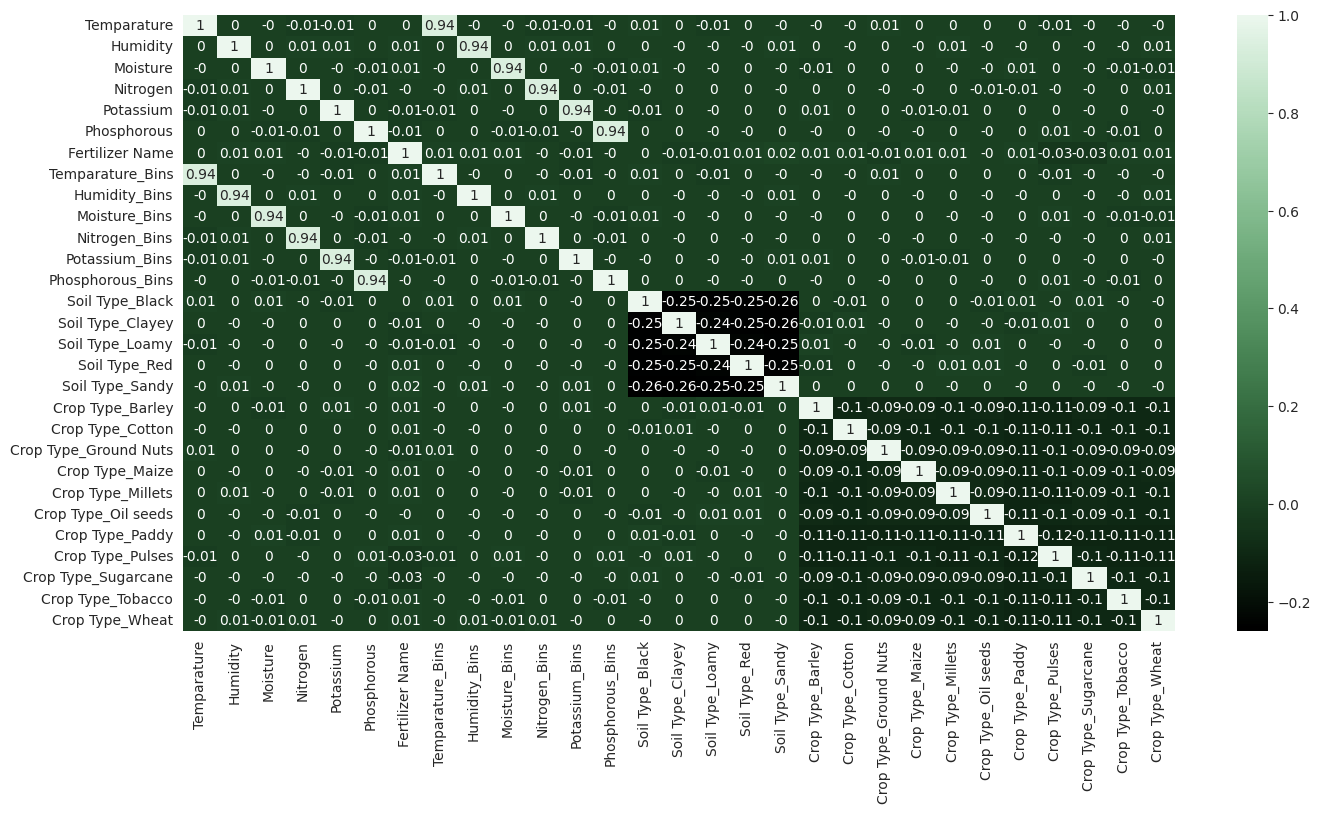

In [60]:
# We graph the correlation between the variables

matrix_fertilizers = df_encoded.corr(numeric_only=True).round(2)

plt.figure(figsize=(16, 8))

sns.heatmap(
    matrix_fertilizers, 
    annot=True,
    cmap=sns.cubehelix_palette(
        start=2, rot=0, 
        dark=0, light=.95, 
        reverse=True, as_cmap=True
    ))

We wouldn't be observing a clear linear relationship between the variables, except for the variables grouped by values we created, which logically show a relationship with the variables on which they are based. Later, we'll evaluate mutual information to expand the analysis of how the features relate.

## Scaling

We'll move on to scaling the data where necessary. We'll start by separating the target variable from the features, and then perform a statistical analysis of them to gain an overview of the different scales of the data.

In [61]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,31.503565,4.025574,25.0,28.0,32.0,35.0,38.0
Humidity,750000.0,61.038912,6.647695,50.0,55.0,61.0,67.0,72.0
Moisture,750000.0,45.184147,11.794594,25.0,35.0,45.0,55.0,65.0
Nitrogen,750000.0,23.093808,11.216125,4.0,13.0,23.0,33.0,42.0
Potassium,750000.0,9.478296,5.765622,0.0,4.0,9.0,14.0,19.0
Phosphorous,750000.0,21.073227,12.346831,0.0,10.0,21.0,32.0,42.0
Fertilizer Name,750000.0,2.859791,1.967025,0.0,1.0,3.0,4.0,6.0
Temparature_Bins,750000.0,1.001719,0.844885,0.0,0.0,1.0,2.0,2.0
Humidity_Bins,750000.0,0.960079,0.807891,0.0,0.0,1.0,2.0,2.0
Moisture_Bins,750000.0,1.060707,0.791970,0.0,0.0,1.0,2.0,2.0


By evaluating the scale of the values, we find the original numerical variables with different scales. We will proceed to apply StandardScaler, or we could alternatively apply MinMaxScaler. I encourage you to try different methods for scaling the data, with their corresponding analysis, to find the most optimal tool for scaling the data.

https://scikit-learn.org/stable/api/sklearn.preprocessing.html

In [62]:
# We separate the target variable from the features

x_fertilizers = df_encoded.drop(columns="Fertilizer Name")
y_fertilizers = df_encoded["Fertilizer Name"]

In [63]:
# Numerical variables to scale

fertilizer_numeric = x_fertilizers[[
    "Temparature",
    "Humidity",
    "Moisture",
    "Nitrogen",
    "Potassium",
    "Phosphorous"
]]

scaler = StandardScaler().set_output(transform="pandas")
scale_num = scaler.fit_transform(fertilizer_numeric)

# We create a df with the remaining variables

fertilizer_rest = x_fertilizers.drop(columns=[
    "Temparature",
    "Humidity",
    "Moisture",
    "Nitrogen",
    "Potassium",
    "Phosphorous"
])

# We concatenate the dataframes

x_end = pd.concat([scale_num, fertilizer_rest], axis=1)

In [64]:
x_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temparature            750000 non-null  float64
 1   Humidity               750000 non-null  float64
 2   Moisture               750000 non-null  float64
 3   Nitrogen               750000 non-null  float64
 4   Potassium              750000 non-null  float64
 5   Phosphorous            750000 non-null  float64
 6   Temparature_Bins       750000 non-null  float64
 7   Humidity_Bins          750000 non-null  float64
 8   Moisture_Bins          750000 non-null  float64
 9   Nitrogen_Bins          750000 non-null  float64
 10  Potassium_Bins         750000 non-null  float64
 11  Phosphorous_Bins       750000 non-null  float64
 12  Soil Type_Black        750000 non-null  float64
 13  Soil Type_Clayey       750000 non-null  float64
 14  Soil Type_Loamy        750000 non-null  f

In [65]:
x_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,-2.430625e-16,1.000001,-1.615563,-0.870328,0.123320,0.868556,1.613792
Humidity,750000.0,-5.286627e-16,1.000001,-1.660563,-0.908422,-0.005853,0.896716,1.648856
Moisture,750000.0,2.707263e-16,1.000001,-1.711306,-0.863459,-0.015613,0.832234,1.680080
Nitrogen,750000.0,3.865352e-17,1.000001,-1.702354,-0.899938,-0.008364,0.883210,1.685627
Potassium,750000.0,-5.222015e-17,1.000001,-1.643934,-0.950166,-0.082957,0.784253,1.651463
Phosphorous,750000.0,-2.046363e-18,1.000001,-1.706773,-0.896848,-0.005931,0.884987,1.694912
Temparature_Bins,750000.0,1.001719e+00,0.844885,0.000000,0.000000,1.000000,2.000000,2.000000
Humidity_Bins,750000.0,9.600787e-01,0.807891,0.000000,0.000000,1.000000,2.000000,2.000000
Moisture_Bins,750000.0,1.060707e+00,0.791970,0.000000,0.000000,1.000000,2.000000,2.000000
Nitrogen_Bins,750000.0,1.005467e+00,0.781365,0.000000,0.000000,1.000000,2.000000,2.000000


We complete the scaling of the data. Next, we will evaluate the mutual information and analyze possible feature reduction based on the overall results.

## Feature Selection

We will start by applying 'mutual_info_classif', to analyze the possible dependencies between the variables and how much knowledge is obtained from one by observing the other, how much information one variable provides about the other.

In [66]:
fertilizers_scores = mutual_info_classif(x_end, y_fertilizers)
fertilizers_scores = pd.Series(fertilizers_scores, name="Fertilizers MI Scores", index=x_end.columns)
fertilizers_scores = fertilizers_scores.sort_values(ascending=False)
fertilizers_scores

Humidity_Bins            0.010568
Potassium_Bins           0.010169
Temparature_Bins         0.009602
Nitrogen_Bins            0.009216
Moisture_Bins            0.009194
Phosphorous_Bins         0.008501
Soil Type_Black          0.004630
Moisture                 0.004043
Phosphorous              0.003593
Soil Type_Sandy          0.003498
Nitrogen                 0.003281
Temparature              0.002802
Soil Type_Red            0.002493
Soil Type_Clayey         0.002211
Potassium                0.002201
Humidity                 0.001893
Crop Type_Cotton         0.001698
Crop Type_Barley         0.001669
Crop Type_Pulses         0.001490
Soil Type_Loamy          0.001319
Crop Type_Ground Nuts    0.001262
Crop Type_Sugarcane      0.001180
Crop Type_Maize          0.001065
Crop Type_Wheat          0.000879
Crop Type_Millets        0.000617
Crop Type_Tobacco        0.000396
Crop Type_Oil seeds      0.000082
Crop Type_Paddy          0.000000
Name: Fertilizers MI Scores, dtype: float64

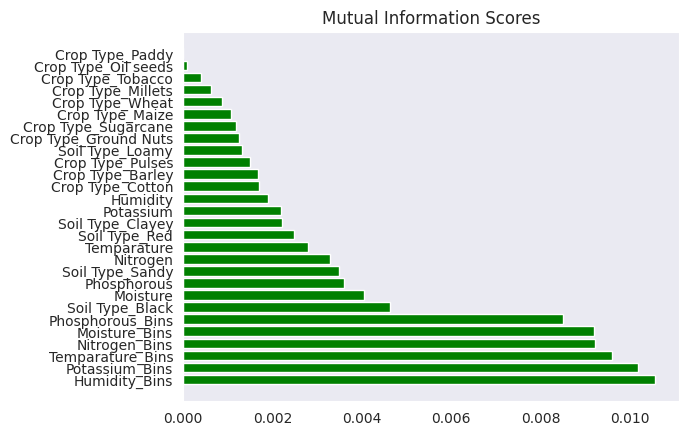

<Figure size 800x500 with 0 Axes>

In [67]:
scores = fertilizers_scores.sort_values(ascending=True)
width = np.arange(len(fertilizers_scores))
ticks = list(fertilizers_scores.index)
plt.barh(width, fertilizers_scores, color="g")
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()

From this analysis, we can see that some columns exhibit independence with values of zero, and that the grouped columns created show a stronger relationship. We could use the insights obtained to perform some transformations and expand our features. We could perform a reduction, but we will keep all the variables until we perform our first approach and analyze the results, as well as the feature importance. We could also apply PCA (Principal Component Analysis) to the encoded crop and soil columns to generate a new set of variables and reduce dimensionality. We will continue with our selection of models and their corresponding performance evaluation.

# Model Selection

We'll test four classification models, which we'll evaluate and try to optimize to get a first approach at the competition. We'll start by developing some useful functions, in addition to separate the data into training and validation sets.

In [68]:
# We separate the data into training and validation sets

x_train, x_val, y_train, y_val = (
    train_test_split(x_end, y_fertilizers, test_size=0.2, random_state=42)
)

In [69]:
# We review the balance of the target variable

values_counts = np.asarray(np.unique(y_train, return_counts=True))

print(values_counts)

[[    0     1     2     3     4     5     6]
 [91046 91797 89689 88879 88774 75712 74103]]


Taking into account the competition metrics, a documentation scan and analysis, and community discussions, we obtain this basic function that will help us address and evaluate the problem. I'm sharing the link to the GitHub repository. This link was shared by other community members in the aforementioned discussions, in the corresponding section of the playground competition.

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

In [70]:
# Function to calculate AP@K and then MAP@K

def apk(actual, predicted, k):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score

def mapk(actual, predicted, k):

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

Next, we develop a function to evaluate the models with the respective metric, and thus obtain an initial performance, with which to start. The function takes the chosen model, the validation data, the encoder we chose for the target variable, to obtain the names of the original classes, the value of k for the metric function, and the name of the model (string) to correctly identify the outputs and insights obtained.

In [71]:
# Function for an initial evaluation of the model

def evaluator(model, val_x, val_y, enc, k, model_name):
    
    y_pred_prob = model.predict_proba(val_x)
    top_3_indices_val = np.argsort(-y_pred_prob, axis=1)[:, :3]
    
    predicted_val = []
    
    for row_indices in top_3_indices_val:
        names = enc.inverse_transform(row_indices)
        predicted_val.append(list(names))
    
    actual_val = [[enc.inverse_transform([label])[0]] for label in val_y]
    map_3_score_val = mapk(actual_val, predicted_val, k=k)
    
    print(f"\n{model_name} initial MAP@3 Score: {map_3_score_val:.4f}")

Finally, we will use StratifiedKFold to evaluate the model with a cross-validation scheme, and we will create a function to apply to each model. You can change the next cell to use a different CV method, and modify or adapt the function if you wish, you could include the CV method in the function and pass the number of 'n_splits' as a parameter.

https://scikit-learn.org/stable/modules/cross_validation.html

In [72]:
# we create the StratifiedKFold object

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [73]:
# Function to evaluate models with a cross-validation method

def cv_evaluator(model_class, model_params, x, y, enc, k_map, model_name):

    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):

        print(f"\nFold {fold + 1}/{n_splits}")
        x_train_fold, x_val_fold = x.iloc[train_idx], x.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model = model_class(**model_params)
        model.fit(x_train_fold, y_train_fold)

        y_pred_prob = model.predict_proba(x_val_fold)
        top_k_indices_val = np.argsort(-y_pred_prob, axis=1)[:, :k_map]

        predicted_fold = []

        for row_indices in top_k_indices_val:

            valid_indices = [idx for idx in row_indices if idx < len(enc.classes_)]
            names = enc.inverse_transform(valid_indices)
            predicted_fold.append(list(names))

        actual_fold = [[enc.inverse_transform([label])[0]] for label in y_val_fold]

        fold_map_score = mapk(actual_fold, predicted_fold, k=k_map)
        fold_scores.append(fold_map_score)
        print(f"MAP@{k_map} Fold {fold + 1}: {fold_map_score:.4f}")

    print(f"\n--- CV Summary for {model_name} ---\n")
    print(f"MAP@{k_map} Scores for fold: {np.round(fold_scores, 4)}")
    print(f"MAP@{k_map} average: {np.mean(fold_scores):.4f}")
    print(f"Standard deviation of MAP@{k_map}: {np.std(fold_scores):.4f}")

    return fold_scores

The function takes as parameters the model class, the parameter dictionary to initialize the model (use '.get_params()' for default), the complete dataset (The CV method is responsible for creating the training and validation splits within the function for each fold), the encoder selected for the target variable (prepare the true labels for the metric), the value of 'k' for the MAP@k metric, and the name of the model to print results.

Essentially, the function creates a new model instance for each fold, train the model, predict the probabilities on the fold's validation set, obtain the top-K indices from the predictions, map the indices to fertilizer names, calculate the MAP@K for each fold, and prepare the true labels for the metric.
All of this ensures that each fold is trained independently and that the evaluation is unbiased, returning a list of MAP@K scores per fold.

## First model: LogisticRegression

As a first model we will use logistic regression, a type of supervised ML algorithm, widely used in various fields, ideal for probability classification tasks. Instead of directly predicting the outcome, logistic regression uses the sigmoid function (also known as the logistic function) to map the output of a linear equation to a probability.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [74]:
# We create the model instance

lrc = LogisticRegression(multi_class="multinomial")

# Train the model with the data

lrc.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial')

In [75]:
evaluator(lrc, x_val, y_val, le, 3, "LogisticRegression")


LogisticRegression initial MAP@3 Score: 0.2888


An initial analysis of the model yields a reasonable result. Optimizing the model could improve performance. We will then evaluate it using a CV method.

In [76]:
# We apply the function for CV

lrc_params = {"multi_class": "multinomial", "random_state": 42}

lrc_cv_scores = cv_evaluator(
    model_class=LogisticRegression,
    model_params=lrc_params,
    x=x_end,
    y=y_fertilizers, 
    enc=le,
    k_map=3,
    model_name="Logistic Regression"
)


Fold 1/5
MAP@3 Fold 1: 0.2878

Fold 2/5
MAP@3 Fold 2: 0.2892

Fold 3/5
MAP@3 Fold 3: 0.2872

Fold 4/5
MAP@3 Fold 4: 0.2878

Fold 5/5
MAP@3 Fold 5: 0.2888

--- CV Summary for Logistic Regression ---

MAP@3 Scores for fold: [0.2878 0.2892 0.2872 0.2878 0.2888]
MAP@3 average: 0.2882
Standard deviation of MAP@3: 0.0007


We found no significant differences. The model maintains an average of 0.2882, with results close to the initial ones. We will continue with the next model.

## Second model: XGBClassifier

For our second model, we chose XGBClassifier, an implementation of gradient boosted decision trees designed for speed and performance. It's widely used for both classification and regression tasks, known for its speed, accuracy, and ability to handle large datasets.

https://xgboost.readthedocs.io/en/stable/get_started.html

In [77]:
# We create the model instance

xgbc = XGBClassifier()

# Train the model with the data

xgbc.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [78]:
evaluator(xgbc, x_val, y_val, le, 3, "XGBClassifier")


XGBClassifier initial MAP@3 Score: 0.3307


We found a result superior to the first model. Again, by optimizing the model and improving the previous stages, as well as developing more feature engineering, we could improve these results. We will proceed to evaluate using a CV method.

In [79]:
# We apply the function for CV

xgbc_params = xgbc.get_params()

lrc_cv_scores = cv_evaluator(
    model_class=XGBClassifier,
    model_params=xgbc_params,
    x=x_end,
    y=y_fertilizers, 
    enc=le,
    k_map=3,
    model_name="XGBClassifier"
)


Fold 1/5
MAP@3 Fold 1: 0.3294

Fold 2/5
MAP@3 Fold 2: 0.3306

Fold 3/5
MAP@3 Fold 3: 0.3304

Fold 4/5
MAP@3 Fold 4: 0.3308

Fold 5/5
MAP@3 Fold 5: 0.3305

--- CV Summary for XGBClassifier ---

MAP@3 Scores for fold: [0.3294 0.3306 0.3304 0.3308 0.3305]
MAP@3 average: 0.3303
Standard deviation of MAP@3: 0.0005


We found general results within the initial, with an average of 0.3303. Increasing the number of splits could give us more insights. We will proceed to the following model.

## Third model: LGBMClassifier

Light Gradient Boosting Machine, is a high-performance gradient boosting system, developed for efficient and scalable machine learning applications. It is created expressly for speed and accuracy. Some important characteristics include support for parallel and distributed processing, the ability to manage enormous datasets, and better gradient-boosting techniques.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [80]:
# We create the model instance

lgbmc = LGBMClassifier()

# Train the model with the data

lgbmc.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 28
[LightGBM] [Info] Start training from score -1.885565
[LightGBM] [Info] Start training from score -1.877350
[LightGBM] [Info] Start training from score -1.900582
[LightGBM] [Info] Start training from score -1.909654
[LightGBM] [Info] Start training from score -1.910836
[LightGBM] [Info] Start training from score -2.069993
[LightGBM] [Info] Start training from score -2.091474


LGBMClassifier()

In [81]:
evaluator(lgbmc, x_val, y_val, le, 3, "LGBMClassifier")


LGBMClassifier initial MAP@3 Score: 0.3230


We found a lower initial result than the previous one. Again, as with the other models, we could improve these results by optimizing the model.

In [82]:
# We apply the function for CV

lgbmc_params = lgbmc.get_params()

lrc_cv_scores = cv_evaluator(
    model_class=LGBMClassifier,
    model_params=lgbmc_params,
    x=x_end,
    y=y_fertilizers, 
    enc=le,
    k_map=3,
    model_name="LGBMClassifier"
)


Fold 1/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 28
[LightGBM] [Info] Start training from score -1.884862
[LightGBM] [Info] Start training from score -1.880055
[LightGBM] [Info] Start training from score -1.897542
[LightGBM] [Info] Start training from score -1.911546
[LightGBM] [Info] Start training from score -1.909125
[LightGBM] [Info] Start training from score -2.067671
[LightGBM] [Info] Start training from score -2.094839
MAP@3 Fold 1: 0.3219

Fold 2/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

We continue to find the same previous results. The model maintains an average of 0.3227. Next, we will test the last selected model, using one of the previously trained models as the base estimator.

## Fourth model: BaggingClassifier

For our latest model we chose BaggingClassifier, an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator, by introducing randomization into its construction procedure and then making an ensemble out of it. We will use XGBC as the base estimator, since it was the model with the best initial result. If None, then the base estimator is a DecisionTreeClassifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [83]:
# We create the model instance

#bagc = BaggingClassifier(estimator=xgbc)

# Train the model with the data

#bagc.fit(x_train, y_train)

In [84]:
#evaluator(bagc, x_val, y_val, le, 3, "BaggingClassifier")

We managed to improve on previous initial results by a small amount, but we managed to find the model with the best initial performance.

BaggingClassifier initial MAP@3 Score: 0.2819 - Base estimator DecisionTreeClassifier (default estimator)

BaggingClassifier initial MAP@3 Score: 0.3344 - Base estimator XGBClassifier

In [85]:
'''
# We apply the function for CV

bagc_params = {"estimator" : xgbc}

lrc_cv_scores = cv_evaluator(
    model_class=BaggingClassifier,
    model_params=bagc_params,
    x=x_end,
    y=y_fertilizers, 
    enc=le,
    k_map=3,
    model_name="BaggingClassifier"
)
'''

'\n# We apply the function for CV\n\nbagc_params = {"estimator" : xgbc}\n\nlrc_cv_scores = cv_evaluator(\n    model_class=BaggingClassifier,\n    model_params=bagc_params,\n    x=x_end,\n    y=y_fertilizers, \n    enc=le,\n    k_map=3,\n    model_name="BaggingClassifier"\n)\n'

--- CV Summary for BaggingClassifier ---

MAP@3 Scores for fold: [0.3338 0.3342 0.3352 0.3345 0.3345]

MAP@3 average: 0.3344

Standard deviation of MAP@3: 0.0004

We can observe general results within the initial model, with an average of 0.3344. We will attempt to optimize the model to improve the general result. In addition, we will evaluate the importance of the features, to assess the impact of each variable in our model.

It is also important to evaluate, from this point, returning to previous stages to analyze new feature engineering approaches, different data preprocessing methods, as well as testing a wider or different variety of models, or more robust ensemble methods. Next, we will attempt to perform a bit of modeling, with the goal of improving the overall result of the selected model with the best initial performance.

# Modeling

Next, we'll attempt to optimize the model we selected as the base estimator for the ensemble. To do so, we'll use RandomizedSearchCV, a variant of grid search that takes random samples from the set of possible values, rather than trying every combination. This can be more efficient than grid search, as it doesn't need to evaluate every possible combination. However, it can be computationally expensive, with a high number of hyperparameters. Also, StratifiedKFold cross-validation method, and we'll evaluate with 'accuracy_score'.

In [86]:
# We establish the parameters to test

params_grid = {
    "n_estimators": [100, 150],
    "max_depth" : [6, 8],
    "gamma" : [0, 1],
    "alpha" : [0, 1],
    "subsample" : [0.5, 1],
    "scale_pos_weight" : [1, 2]
}

# We use random search to evaluate the grid

xgbc_grid = RandomizedSearchCV(
    XGBClassifier(),
    params_grid,
    cv=skf,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search = xgbc_grid.fit(x_train, y_train)

print(
    f"Parameters: {xgbc_search.best_params_}\nScore: {xgbc_search.best_score_}"
)

Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'n_estimators': 150, 'max_depth': 8, 'gamma': 0, 'alpha': 1}
Score: 0.19469


In [87]:
# We save the results within a dataframe

xgbc_cv_results = pd.DataFrame(xgbc_search.cv_results_)

xgbc_cv_results.head().sort_values(by="rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_max_depth,param_gamma,param_alpha,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,29.321422,0.458177,1.780919,0.254878,1,2,100,8,0,1,...,0.193170,0.001527,2,0.386371,0.388335,0.387010,0.386738,0.388062,0.387303,0.000764
0,39.005902,0.511966,1.463733,0.159360,0.5,1,150,6,0,1,...,0.191912,0.000410,3,0.272956,0.273662,0.272810,0.272969,0.272758,0.273031,0.000326
4,26.091211,0.146614,0.895809,0.007073,0.5,2,100,6,0,1,...,0.189518,0.000611,5,0.254392,0.254512,0.254542,0.255113,0.254208,0.254553,0.000303
1,31.504658,0.137187,1.529339,0.034501,0.5,2,100,8,1,0,...,0.186693,0.000757,7,0.353287,0.354475,0.353402,0.355231,0.354294,0.354138,0.000721
3,22.289269,0.572335,0.463914,0.002392,1,2,150,6,1,1,...,0.186555,0.000765,8,0.225646,0.224912,0.224288,0.224358,0.224713,0.224783,0.000488


We have managed to test some parameter variants to evaluate the model, and we save the results in a data frame for analysis. A broader number of hyperparameters could give better results, as well as different methods, such as Bayesian optimization, a more sophisticated technique that uses Bayesian methods to model the underlying function that maps hyperparameters to the model performance. It tries to find the optimal set of hyperparameters by making smart guesses based on the previous results. For time reasons, we'll stick with this simple approach as a guide, but I encourage you to try a broader grid and other methods.

In [88]:
# We fit the best estimator

xgbc_result = xgbc_search.best_estimator_  
xgbc_result.fit(x_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [89]:
evaluator(xgbc_result, x_val, y_val, le, 3, "XGBClassifier initial optimization")


XGBClassifier initial optimization initial MAP@3 Score: 0.3332


Evaluating the results, compared to the initial model, we managed to slightly improve the model's performance. Now, we will use it again with BaggingClassifier as the base estimator, to evaluate the new result, and define the final model.

In [90]:
# We create the model instance

bagc = BaggingClassifier(estimator=xgbc_result)

# Train the model with the data

bagc.fit(x_train, y_train)

BaggingClassifier(estimator=XGBClassifier(alpha=1, base_score=None,
                                          booster=None, callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=8,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=150,
                                          n_jobs=None, num_parallel_tree=None, ...))

In [91]:
evaluator(bagc, x_val, y_val, le, 3, "BaggingClassifier")


BaggingClassifier initial MAP@3 Score: 0.3394


We've managed to improve the ensemble result. Next, we'll define the final model and evaluate the importance of the features.

In [92]:
# We define the final model

final_model = bagc

# We obtain the final parameters of the model

final_model.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__objective': 'multi:softprob',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': 0,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': 8,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 '

To evaluate the importance of features, we will use 'Permutation feature importance', which assesses the importance of individual features by measuring how much the model's performance degrades when a feature's values are randomly shuffled or permuted, it quantifies how much the model relies on a particular feature for making accurate predictions.

https://scikit-learn.org/stable/modules/permutation_importance.html

In [93]:
# Permutation Importance

perm_importance = permutation_importance(final_model, x_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': x_end.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})
print("\nPermutation Importance:\n")
print(perm_importance_df.sort_values(by='Importance Mean', ascending=False))


Permutation Importance:

                  Feature  Importance Mean  Importance Std
5             Phosphorous         0.019978        0.000720
3                Nitrogen         0.016844        0.000854
2                Moisture         0.016273        0.000816
4               Potassium         0.012370        0.000668
1                Humidity         0.008469        0.000449
0             Temparature         0.007682        0.000703
24       Crop Type_Pulses         0.001904        0.000279
16        Soil Type_Sandy         0.001874        0.000297
13       Soil Type_Clayey         0.001778        0.000295
19  Crop Type_Ground Nuts         0.001567        0.000184
22    Crop Type_Oil seeds         0.001530        0.000252
12        Soil Type_Black         0.001432        0.000284
21      Crop Type_Millets         0.001411        0.000227
25    Crop Type_Sugarcane         0.001402        0.000204
23        Crop Type_Paddy         0.001396        0.000272
27        Crop Type_Wheat     

Feature importance allows us to evaluate how each variable impacts our model and make appropriate decisions. The 'permutation_importance' method is computationally very expensive. I encourage you to try other methods. Next, we'll load the test data and apply our model to previously unseen data.